# Multi-GPU Computation Implementation from Scratch

:label:`chapter_multi_gpu`


In this section, we will show how to use multiple GPU for computation. For example, we can train the same model using multiple GPUs. As you might expect, running the programs in this section requires at least two GPUs. In fact, installing multiple GPUs on a single machine is common because there are usually multiple PCIe slots on the motherboard. If the NVIDIA driver is properly installed, we can use the `nvidia-smi` command to view all GPUs on the current computer.

In [1]:
!nvidia-smi

Fri Jul  5 23:47:18 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|


|   0  Tesla V100-SXM2...  Off  | 00000000:00:1B.0 Off |                    0 |
| N/A   47C    P0    54W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:00:1C.0 Off |                    0 |
| N/A   46C    P0    55W / 300W |   3138MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  Tesla V100-SXM2...  Off  | 00000000:00:1D.0 Off |                    0 |
| N/A   46C    P0    58W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   3  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   47C    P0    57W / 300W |   1038MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                        

As we discussed in
:numref:`chapter_auto_para`, most operations can use all the computational resources of all CPUs, or
all computational resources of a single GPU. However, if we use multiple GPUs
for model training, we still need to implement the corresponding algorithms. Of
these, the most commonly used algorithm is called data parallelism.


## Data Parallelism

In the deep learning field, Data Parallelism is currently the most widely used
method for dividing model training tasks among multiple GPUs. Recall the process
for training models using optimization algorithms described in
:numref:`chapter_minibatch_sgd`. Now, we will demonstrate how data parallelism works using mini-batch
stochastic gradient descent as an example.

Assume there are $k$ GPUs on a machine. Given the model to be trained, each GPU will maintain a complete set of model parameters independently. In any iteration of model training, given a random mini-batch, we divide the examples in the batch into $k$ portions and distribute one to each GPU. Then, each GPU will calculate the local gradient of the model parameters based on the mini-batch subset it was assigned and the model parameters it maintains. Next, we add together the local gradients on the $k$ GPUs to get the current mini-batch stochastic gradient. After that, each GPU uses this mini-batch stochastic gradient to update the complete set of model parameters that it maintains. Figure 10.1 depicts the mini-batch stochastic gradient calculation using data parallelism and two GPUs.

![Calculation of mini-batch stochastic gradient using data parallelism and two GPUs. ](../img/data-parallel.svg)

In order to implement data parallelism in a multi-GPU training scenario from scratch, we first import the required packages or modules.

In [2]:
%matplotlib inline
import d2l
from mxnet import autograd, np, npx, gluon
npx.set_np()

## Define the Model

We use LeNet, introduced in :numref:`chapter_lenet`, as the sample model for this section. Here, the model implementation only uses ndarrays.

In [3]:
# Initialize model parameters
scale = 0.01
W1 = np.random.normal(scale=scale, size=(20, 1, 3, 3))
b1 = np.zeros(20)
W2 = np.random.normal(scale=scale, size=(50, 20, 5, 5))
b2 = np.zeros(50)
W3 = np.random.normal(scale=scale, size=(800, 128))
b3 = np.zeros(128)
W4 = np.random.normal(scale=scale, size=(128, 10))
b4 = np.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# Define the model
def lenet(X, params):
    h1_conv = npx.convolution(data=X, weight=params[0], bias=params[1],
                              kernel=(3, 3), num_filter=20)
    h1_activation = npx.relu(h1_conv)
    h1 = npx.pooling(data=h1_activation, pool_type='avg', kernel=(2, 2),
                    stride=(2, 2))
    h2_conv = npx.convolution(data=h1, weight=params[2], bias=params[3],
                              kernel=(5, 5), num_filter=50)
    h2_activation = npx.relu(h2_conv)
    h2 = npx.pooling(data=h2_activation, pool_type='avg', kernel=(2, 2),
                    stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = np.dot(h2, params[4]) + params[5]
    h3 = npx.relu(h3_linear)
    y_hat = np.dot(h3, params[6]) + params[7]
    return y_hat

# Cross-entropy loss function
loss = gluon.loss.SoftmaxCrossEntropyLoss()

## Synchronize Data Among Multiple GPUs

We need to implement some auxiliary functions to synchronize data among the multiple GPUs. The following `get_params` function copies the model parameters to a specific GPU and initializes the gradient.

In [4]:
def get_params(params, ctx):
    new_params = [p.copyto(ctx) for p in params]
    for p in new_params:
        p.attach_grad()
    return new_params

Try to copy the model parameter `params` to `gpu(0)`.

In [5]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] @gpu(0)
b1 grad: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] @gpu(0)


Here, the data is distributed among multiple GPUs. The following `allreduce` function adds up the data on each GPU and then broadcasts it to all the GPUs.

In [6]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].copyto(data[0].context)
    for i in range(1, len(data)):
        data[0].copyto(data[i])

Perform a simple test of the `allreduce` function.

In [7]:
data = [np.ones((1, 2), ctx=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 [[1. 1.]] @gpu(0) 
 [[2. 2.]] @gpu(1)
after allreduce:
 [[3. 3.]] @gpu(0) 
 [[3. 3.]] @gpu(1)


## Split a Data Batch into Multiple GPUs

The `utils` module in Gluon provides a function to evenly split an array into multiple parts along the first dimension, and then copy the $i$-th part into the the $i$-th device. It's straightforward to implement, but we will use the pre-implemented version so later chapters can reuse the `split_batch` function we will define later.

Now, we try to divide the 6 data instances equally between 2 GPUs using the `split_and_load` function.

In [8]:
data = np.arange(24).reshape(4, 6)
ctx = d2l.try_all_gpus()
splitted = gluon.utils.split_and_load(data, ctx)
print('input: ', data)
print('load into', ctx)
print('output:', splitted)

input:  [[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]
 [18. 19. 20. 21. 22. 23.]]
load into [gpu(0), gpu(1)]
output: [array([[ 0.,  1.,  2.,  3.,  4.,  5.],
       [ 6.,  7.,  8.,  9., 10., 11.]], ctx=gpu(0)), array([[12., 13., 14., 15., 16., 17.],
       [18., 19., 20., 21., 22., 23.]], ctx=gpu(1))]


The `split_batch` function then splits both the features and labels.

In [9]:
# Save to the d2l package.
def split_batch(X, y, ctx_list):
    """Split X and y into multiple devices specified by ctx"""
    assert X.shape[0] == y.shape[0]
    return (gluon.utils.split_and_load(X, ctx_list),
            gluon.utils.split_and_load(y, ctx_list))

## Multi-GPU Training on a Single Mini-batch

Now we can implement multi-GPU training on a single mini-batch. Its implementation is primarily based on the data parallelism approach described in this section. We will use the auxiliary functions we just discussed, `allreduce` and `split_and_load`, to synchronize the data among multiple GPUs.

In [10]:
def train_batch(X, y, gpu_params, ctx_list, lr):
    gpu_Xs, gpu_ys = split_batch(X, y, ctx_list)
    with autograd.record():  # Loss is calculated separately on each GPU
        ls = [loss(lenet(gpu_X, gpu_W), gpu_y)
              for gpu_X, gpu_y, gpu_W in zip(gpu_Xs, gpu_ys, gpu_params)]
    for l in ls:  # Back Propagation is performed separately on each GPU
        l.backward()
    # Add up all the gradients from each GPU and then broadcast them to all
    # the GPUs
    for i in range(len(gpu_params[0])):
        allreduce([gpu_params[c][i].grad for c in range(len(ctx_list))])
    # The model parameters are updated separately on each GPU
    for param in gpu_params:
        d2l.sgd(param, lr, X.shape[0])  # Here, we use a full-size batch

## Training Functions

Now, we can define the training function. Here the training function is slightly different from the one used in the previous chapter. For example, here, we need to copy all the model parameters to multiple GPUs based on data parallelism and perform multi-GPU training on a single mini-batch for each iteration.

In [11]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    ctx_list = [d2l.try_gpu(i) for i in range(num_gpus)]
    # Copy model parameters to num_gpus GPUs
    gpu_params = [get_params(params, c) for c in ctx_list]
    num_epochs, times, acces = 10, [], []
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # Perform multi-GPU training for a single mini-batch
            train_batch(X, y, gpu_params, ctx_list, lr)
            npx.waitall()
        timer.stop()
        # Verify the model on GPU 0
        animator.add(epoch+1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, gpu_params[0]), test_iter, ctx[0]),))
    print('test acc: %.2f, %.1f sec/epoch on %s' % (
            animator.Y[0][-1], timer.avg(), ctx_list))


## Multi-GPU Training Experiment

We will start by training with a single GPU. Assume the batch size is 256 and the learning rate is 0.2.

test acc: 0.81, 1.8 sec/epoch on [gpu(0)]


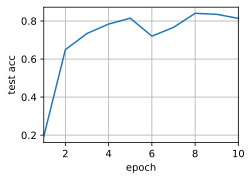

In [12]:
train(num_gpus=1, batch_size=256, lr=0.2)

By keeping the batch size and learning rate unchanged and changing the number of GPUs to 2, we can see that the improvement in test accuracy is roughly the same as in the results from the previous experiment. In terms of the optimization algorithms, they are identical.

Because of the extra communication overhead, and relative simple model we used here, there is no reduction in the training time. We will consider a more complex model in the next chapter.

test acc: 0.82, 2.6 sec/epoch on [gpu(0), gpu(1)]


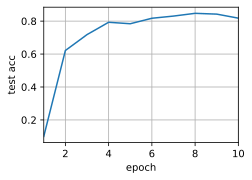

In [13]:
train(num_gpus=2, batch_size=256, lr=0.2)

## Summary

* We can use data parallelism to more fully utilize the computational resources of multiple GPUs to implement multi-GPU model training.
* With the same hyper-parameters, the training accuracy of the model is roughly equivalent when we change the number of GPUs.

## Exercises

* In a multi-GPU training experiment, use 2 GPUs for training and double the `batch_size` to 512. How does the training time change? If we want a test accuracy comparable with the results of single-GPU training, how should the learning rate be adjusted?
* Change the model prediction part of the experiment to multi-GPU prediction.

## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2383)

![](../img/qr_multiple-gpus.svg)